In [30]:
from transformers import get_linear_schedule_with_warmup
from transformers import DistilBertForSequenceClassification,DistilBertTokenizerFast
from train_eval import train
from data_pipeline import data_pipeline
import evaluate
import torch
from torch import nn
from torch.optim import AdamW, Adam
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm, trange
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# hyperparameters
MAX_LEN = 150
BATCH_SIZE = 16
EPOCHS = 5
LR = 1e-5

In [3]:
data = pd.read_csv('data.csv')

In [44]:
data_view = data.sample(frac = 1)
data_view.head(10)

,content,sentiment
4359,Fine,1
2494,Super cool that you've added a garbage AI feat...,0
949,Quit nice though tiktok lite is faster in load...,2
8045,It's good but I'd appreciate it if they remove...,2
6980,Niraj💔😇 bihari,2
5996,"""Open in External Browser"" has been broken for...",0
2752,"More updates come, more bugs come. It's sicken...",0
9519,Unman m baba,2
8777,This app is really good! But filters is not ab...,0
11163,The app's performance is degrading. It crashes...,0


In [7]:
PRE_TRAINED_MODEL_NAME = 'distilbert/distilbert-base-uncased'
tokenizer = DistilBertTokenizerFast.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [8]:
train_dataloader, val_dataloader, test_dataloader = data_pipeline(tokenizer,data,BATCH_SIZE,MAX_LEN)

In [35]:
class_names = ['negative', 'neutral', 'positive']

In [13]:
model = DistilBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME, num_labels=3).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
optimizer = AdamW(model.parameters(), lr=LR)

total_steps = len(train_dataloader)*EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

### Training Loop

In [16]:
model_results = train(model=model, 
                        train_dataloader=train_dataloader,
                        val_dataloader=val_dataloader,
                        optimizer=optimizer,
                        scheduler=scheduler,
                        epochs=EPOCHS)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

train_steps:   0%|          | 0/675 [00:00<?, ?it/s]

val_steps:   0%|          | 0/75 [00:00<?, ?it/s]

Train loss: 0.9279 | Train accuracy: 54%
Val   loss: 0.832 | Val   accuracy: 63%


train_steps:   0%|          | 0/675 [00:00<?, ?it/s]

val_steps:   0%|          | 0/75 [00:00<?, ?it/s]

Train loss: 0.8069 | Train accuracy: 62%
Val   loss: 0.8208 | Val   accuracy: 62%


train_steps:   0%|          | 0/675 [00:00<?, ?it/s]

val_steps:   0%|          | 0/75 [00:00<?, ?it/s]

Train loss: 0.7249 | Train accuracy: 68%
Val   loss: 0.837 | Val   accuracy: 62%


train_steps:   0%|          | 0/675 [00:00<?, ?it/s]

val_steps:   0%|          | 0/75 [00:00<?, ?it/s]

Train loss: 0.6514 | Train accuracy: 72%
Val   loss: 0.8664 | Val   accuracy: 61%


train_steps:   0%|          | 0/675 [00:00<?, ?it/s]

val_steps:   0%|          | 0/75 [00:00<?, ?it/s]

Train loss: 0.598 | Train accuracy: 76%
Val   loss: 0.8758 | Val   accuracy: 62%


In [32]:
model_results['train_loss'] = torch.tensor(model_results['train_loss'], device='cpu')
model_results['val_loss'] = torch.tensor(model_results['val_loss'], device='cpu')

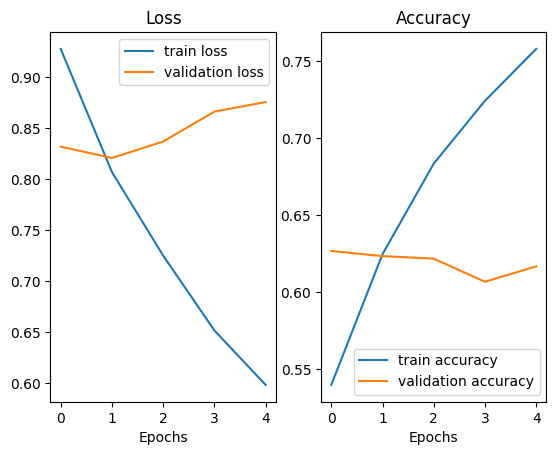

In [33]:
# Plot loss
plt.subplot(1, 2, 1)
plt.plot(model_results['train_loss'].clone().detach(), label='train loss')
plt.plot(model_results['val_loss'].clone().detach(), label='validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(model_results['train_acc'], label='train accuracy')
plt.plot(model_results['val_acc'], label='validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend();

In [36]:
test_metric = evaluate.load("accuracy")
model.eval()
for i,batch in enumerate(test_dataloader):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.inference_mode():
        outputs = model(**batch)
    
    #print(batch)
    print(tokenizer.decode(batch['input_ids'][0], skip_special_tokens=True))
    print()
    logits = outputs.logits
    predictions = torch.softmax(logits,dim=1)
    predictions = torch.argmax(predictions, dim=-1)
    test_metric.add_batch(predictions=predictions, references=batch["labels"])
    print(f"Label : {class_names[predictions.max()]}")
    print("--"*15)

add a post or add a story is not working in my phone. it always ends up as app stop responding. it's frustrating.

Label : negative
------------------------------
i don't like how the feed automatically scrolls to the next post when i'm trying to read a caption. the only way around it is to go to the posters profile, search for that video, and read it from there. pita. also don't care for all the suggested content. i never see any content from the accounts i actually follow. it's just continuous suggested content and ads, one after the other. maybe 10 posts down & finally i come across one from someone i follow. annoying.

Label : negative
------------------------------
late message problem

Label : negative
------------------------------
3stars sorry

Label : neutral
------------------------------
i used to like and use the lite app until they started suggesting marketplace items to me on the menu page. i don't want to see items after i leave the marketplace which is why i turned off 

ever since the latest update this app has been giving me problems i've had a issue where it won't show who's active and i have my active status turned on and sometimes when i open the app it says no internet connection when i'm clearly connected to the internet please fix this issue or im deleting my messenger all together ( it's been a whole month and i'm still having issues with this app i'm about to delete messenger off of my phone if this continues )

Label : negative
------------------------------
so what am mamlm

Label : negative
------------------------------
it is very good for quick. message

Label : positive
------------------------------
facing issue of very slow download speed for every item ( image, video, music and document ). whatever the speed of internet or wifi, not able to download files. second thing telegram is good application for students for study purpose and everyone can't afford telegram premium, so i request developers that they should provide service as the

no idea what happened, but my photos disappear as soon as i upload them. the new album is there and shows however many number of photos there are, but the photos aren't showing up. they've completely disappeared from my timeline and do not show up on the tagged person's page either. this is extremely frustrating, and i haven't been able to get any help from anyone. for the few seconds they're there, when clicked on by someone else, it says there was a problem. i hope this is resolved quickly.

Label : negative
------------------------------


Label : positive
------------------------------
it's like a whole complex world!

Label : positive
------------------------------
almost perfect. i would love settings to be able to change notifications for specific chats. i have multiple chats in the same group, but i don't care about all of them. make it the settings more diffrentiable for each chat. i would love better notifications when i'm @ ed. the notifications aren't there if i don't actua

edeh rosemary mmesoma

Label : negative
------------------------------
все было замечательно, пока закрепленные чаты не стали автоматически перемещаться в списке согласно актуальности

Label : positive
------------------------------
this f word segtasxqwwerrrrdrhncggb

Label : neutral
------------------------------
i can't find any option in the new update to separate group chats from individual chats

Label : neutral
------------------------------
the best and most advanced messenger, that i have ever seen. the best feature of telegram is its serious updates and creative fixes for the flaws it has. its focus on security, encrypted communications, extensive features, and regular updates has made it widely used.

Label : positive
------------------------------
the messenger app has improved greatly with some of the more recent updates. it appears to run faster, with less buffering and crashing. the one thing i don't enjoy is the new tie - in with the facebook app. now you can't use mess

amazing

Label : positive
------------------------------
after last update, i had to uninstall the telegram app. because i cannot upload or download media ( videos, audio, photos ) messages. your inapp bowser is very very slow as compared to whatsapp bowser. 1st it uncompressed the videos than upload on internet, whereas in whatsapp videos can send as it is. all my friends have left or uninstall telegram app. you have to add features like whatsapp regularly otherwise your app rating will go down below the present rating.

Label : negative
------------------------------
syed nournnodi

Label : positive
------------------------------
no ads really good game not for children very inappropriate what is a pretty good game it's really fun you have to be 16 to play

Label : neutral
------------------------------
home feed keeps is just empty and sometimes about 4 - 5 times a week i get something, and even then after that when i traload / refresh the home page it just says " wow, such empty "


bhai yar number ka problem hota ha

Label : negative
------------------------------
they continually rearrange the options, making it progressively harder to use. there's no customer service number, and when attempting to delete one of my accounts, it was challenging ; i couldn't find the option. even when i located it, i couldn't delete it because the app kept crashing. instagram hasn't been the same since fb acquired it.

Label : negative
------------------------------
i facebook some of the time and i put music stories for my friends and family to enjoy. facebook is alright but their friends suggestions suck i get all kinds of weirdos. i reccomend it just don't get in too deep because they control your algorithm and makes to become dependent on it. otherwise you can control it yourself. i keep in contact with my friends and family by it most of the time.

Label : neutral
------------------------------
it's true

Label : positive
------------------------------
it's weird and sus

Lab

good

Label : positive
------------------------------
okay

Label : neutral
------------------------------
i like snapchat, however. i've been having issues with some of the lenses. for example, the age progression lense no longer has the slider for me. i have to take a static photo, so i can not use the video option for that lense. i did not switch phones and i was able to use the slider previously. but all other features are there and i still enjoy the app. i'm able to connect with friends and see what's going on around the world. i do like snapchat, i just want some lenses to actually work. 4 / 5

Label : positive
------------------------------
great

Label : positive
------------------------------
i like it because of its connection is sutible ans also it's easy to creat page or acc. it is not same like facebook meta.

Label : positive
------------------------------
great when it works.. i use this as my main form of contact between my husband and i and also use it to communicate w

yu uynđa

Label : neutral
------------------------------
very good app

Label : positive
------------------------------
ai has been terrible at remembering things lately and often makes actions on the user's behalf. definitely needs a lesson in remembering roles and genders as well as the difference between the user and the ai's chatacter.

Label : neutral
------------------------------
this has been a great app, best messaging app by a distance. the recent changes are great. but it can be improved upon. with people belonging to several chat groups these days, groups chats need to be separated from individuals ', and their should be option to change the default display menu colours and outlook. in short more customization option should be integrated.

Label : positive
------------------------------
i've had a pretty good experience so far on tiktok but i'm now running into an issue. it was working normally until i deleted it and then reinstalled it. it now won't let me long into my acc

no way to turn off all the garbage they throw at you. good luck finding any of the stuff your friends post. update : still mostly ads and garbage. still don't see anything from the people i actually know. also, everything is smashed and doesn't fit on the phone screen with the notification bar on the side now for some reason... massive failure of an app.

Label : negative
------------------------------
mara video viral nahi huta ha

Label : negative
------------------------------
facebook

Label : positive
------------------------------
its really fun, but there's just one probably. its with uploading pictures. it doesn't put the images in order of which they've been saved, it mixes then and it takes forever to find the picture you want to upload even if it's a resent picture. if you could please make it so the pictures are in order of how they were saved in your gallery, that'd be very much so appreciated, thank you : )

Label : positive
------------------------------
feels like it's 

Label : negative
------------------------------
always need to restart

Label : neutral
------------------------------
since i bought a new phone, whatsapp have been blocking me with the claims that i have voilated community rules. but i only use whatsapp to text. i dont know how to use whatsapp negativity. i have missed out on most of my activities just for this. despite reaching the customer care services, the problem keeps coming up. i am getting tired using whatsapp

Label : negative
------------------------------
recent updates have so many bugs. 1 ) instagram no longer can see any photos or videos on my sd card, only internal memory. 2 ) only way i can add a story is by going to my profile and clicking the + at the top. the + on the main feed screen results in an error. 3 ) i no longer have the ability to schedule posts. i used to have it, now it's gone. this is huge for a small business who needs to regularly post content. please fix these issues asap! android user if that makes

it does the basic job of sending messages ok, but if you start a message and switch over to another app, there's a chance you'll lose what you typed ( this has happened several times ). also, it tends to freak out when you are a manager for a group as well, and sometimes it asks you which account you want to use then forgets where it was trying to take you. trying to send someone a dm via facebook tends to be a source of this behavior, where you can't actually send them a message that way.

Label : negative
------------------------------
i can't see past messages. or even just message from other devices

Label : neutral
------------------------------
kay chu * * * a app hai

Label : neutral
------------------------------
the recent upgrade to 4. 01 required the short code to be upgraded ; a process that is relatively straightforward. however, there was a conflict on our site with another plugin, and we reached out for technical support which was not only instantly forthcoming, but invo

i'm giving this app 1 star because it sucks like i've been trying to get into it but it keeps on saying something went wrong please try again it has been a week now, i even contacted them through email i got no reply i've cleared caches and even clear my story and uninstalled and installed still not working pls if it has to do with the new update please remove it cus i'm fed up.

Label : negative
------------------------------
steamy, and the conversations are better than most stuck up wemon i've met who respond with single words... after using this app a while i changed the 5 star to a 3 star, there's no gender preference setting, so you get talked to by guys, girls and " other " as a straight man, this is quite annoying, seeing a buff guy say " hey, babe. "

Label : neutral
------------------------------
when uploading stories, it says error and the red ring around my profile pic shows, but the story never really uploads. it especially happens for videos and when i zoom in and out on

Label : positive
------------------------------
when i click on email links, they just take me to the home page. i have to close the app and click the link again like 2 - 5 times before it actually takes me to the post. it's pretty annoying.

Label : neutral
------------------------------
i really didn't want to use the app but i installed it as reddit is becoming browser - unfriendly on my phone.

Label : negative
------------------------------
a relatively functional app that feels like it's pushing microtransactions as hard as possible. i am asked every time i open the app to join a group, advertised news media " stories ", and now their exclusive ai is always at the top of my page, not my most recent message. the only way that i can find to remove these " features " is to pay $ 3. 50 a month and unlock the buttons to say no thank you.

Label : positive
------------------------------


Label : positive
------------------------------
honestly i've found it a good alternative to other

constant disconnects. only works 1 in 10 times. complete waste of time. makes communication take days. have switched to signal and omw it is stable, never any delays / disconnects and completely secure. just saying.

Label : neutral
------------------------------
excellent

Label : positive
------------------------------
it is cool i just don't like the proses of making an account

Label : positive
------------------------------
the download speed is too low..

Label : neutral
------------------------------
i really like the app as it's a very easy and helpful one. but, the main problem i'm facing with the app is that sometimes i found some messages sent to me which are of importance but can't be opened or viewed with the reason that the app is not updated one. that really got me frustrated many times followed by lot of inconveniences. i will appreciate a lot if this problem would be resolved. thanks

Label : neutral
------------------------------
face book is great social media platfo

i don't know what happen with my fb after updating my fb my message cannot load any longer and it is writing message can't load u guyz should fix it

Label : negative
------------------------------


In [37]:
def get_predictions(model, data_loader):
    
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    model.eval()
    for i,batch in enumerate(test_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.inference_mode():
                outputs = model(**batch)
                texts = tokenizer.decode(batch['input_ids'][0], skip_special_tokens=True)
                targets = batch["labels"].to(device)
                logits = outputs.logits
                preds = torch.softmax(logits,dim=1)
                preds = torch.argmax(preds, dim=-1)
                review_texts.append(texts)
                predictions.append(preds.cpu().item())
                real_values.append(targets.cpu().item())
    
    return review_texts, predictions, real_values

In [38]:
y_review_texts, y_pred, y_test = get_predictions(
  model,
  test_dataloader
)

In [39]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.58      0.56      0.57       190
     neutral       0.46      0.41      0.43       199
    positive       0.62      0.71      0.66       211

    accuracy                           0.56       600
   macro avg       0.55      0.56      0.55       600
weighted avg       0.56      0.56      0.56       600



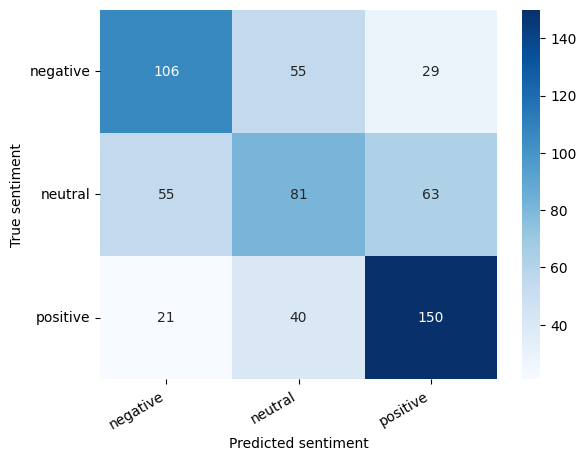

In [40]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

### Predict on raw text

In [60]:
def predict(model, text, tokenizer, device):
    encoded_text = tokenizer(text, truncation=True, padding="max_length",
                             max_length=MAX_LEN, return_tensors='pt')

    input_ids = encoded_text['input_ids'].to(device)
    attention_mask = encoded_text['attention_mask'].to(device)

    outputs = model(input_ids, attention_mask)
    logits = outputs.logits
    preds_prob = torch.softmax(logits,dim=1)
    preds = torch.argmax(preds_prob, dim=-1)

    print(f'Review text: {raw_text}')
    print(f'Sentiment  : {class_names[preds]}')
    print(f'Score  : {preds_prob.max():.4f}')

In [66]:
raw_text = 'Wow! I love this app'
predict(model, raw_text, tokenizer, device)

Review text: Wow! I love this app
Sentiment  : positive
Score  : 0.8840


### Saving Model

In [67]:
saved_model = torch.save(model.state_dict(), 'model_0.bin')
saved_model